In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install upgrade tensorflow
!pip install keras_applications
!pip install keras_preprocessing
!pip show tensorflow

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-nyuvtiu1
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-nyuvtiu1
ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
Name: tensorflow
Version: 2.7.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: protobuf, tensorboard, numpy, flatbuffers, wheel, six, typing-extensions, keras, libclang, astunparse, keras-preprocessing, wrapt, google-pasta, gast, h5py, termcolor, tensorflow-estimator, tensorflow-io-gcs-filesystem, absl-py, opt-einsum, grpcio
Required-by: kapre


In [2]:
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from keras_vggface.utils import preprocess_input
from tensorflow import keras
from keras_vggface.vggface import VGGFace
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import gc
import glob
from collections import defaultdict
from itertools import combinations
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from random import choice, sample
from keras.metrics import AUC, Accuracy
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model 
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import threading


In [3]:
IMG_DIM = (224,224,3)
def read_img(path):
  return preprocess_input( img_to_array( load_img(path, target_size=IMG_DIM) ),version=2)

In [4]:
allPhotos1 = defaultdict(list)
for family in glob.glob("/content/drive/MyDrive/CS 271P Project/train-faces/*"):
  for mem in glob.glob(family+'/*'):
    for photo in glob.glob(mem+'/*'):
      allPhotos1[mem].append(photo)
ppl = list(allPhotos1.keys())
len(ppl)

3553

In [5]:
data = pd.read_csv('/content/drive/MyDrive/CS 271P Project/train-pairs.csv')
data.p1 = data.p1.apply( lambda x: '/content/drive/MyDrive/CS 271P Project/train-faces/'+x )
data.p2 = data.p2.apply( lambda x: '/content/drive/MyDrive/CS 271P Project/train-faces/'+x )
data = data[data.columns[:2]]
data['related'] = 1 
print(data.shape)
data.head()

(6983, 3)


,p1,p2,related
0,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,1
1,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,1
2,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,1
3,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,1
4,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,1


In [6]:

families = glob.glob('/content/drive/MyDrive/CS 271P Project/train-faces/*')
p1 = []; p2 = []
for f1,f2 in combinations(families,2) :
  for _p1 in glob.glob( '{}/*'.format(f1) ):
    for _p2 in glob.glob( '{}/*'.format(f2) ):
      p1.append( _p1 ); p2.append( _p2 );


In [7]:
temp = pd.DataFrame({'p1':p1,'p2':p2,'related':np.zeros( (len(p1),) ,dtype=np.int32)})

In [8]:
temp.shape

(8486648, 3)

In [9]:
temp = temp.sample(n=data.shape[0]*2)
data = data.append(temp).sample(frac=1.).reset_index().drop(['index'],axis=1)
print(data.shape)
data.head()

(20949, 3)


,p1,p2,related
0,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,0
1,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,1
2,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,0
3,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,0
4,/content/drive/MyDrive/CS 271P Project/train-f...,/content/drive/MyDrive/CS 271P Project/train-f...,0


In [10]:
data = data[ ( (data.p1.isin(ppl)) & (data.p2.isin(ppl)) ) ]
data = [ ( x[0], x[1]  ) for x in data.values ]
len(data)

17387

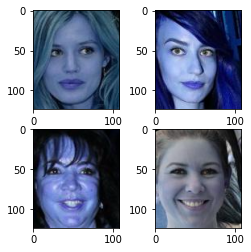

In [11]:
 f, ax = plt.subplots(2, 2, figsize=(4, 4))
batch = sample(data,2)
for i,j in [(0,0),(0,1),(1,0),(1,1)]:
  ax[i][j].imshow( cv2.imread( choice(allPhotos1[batch[i][j]]) ) )

In [12]:
train = [ x for x in data if 'F09' not in x[0]  ]
val = [ x for x in data if 'F09' in x[0]  ]
len(train), len(val)

(14398, 2989)

In [13]:
del data; gc.collect();

In [14]:
def getImages(p1,p2):
    p1 = read_img(choice(allPhotos1[p1]))
    p2 = read_img(choice(allPhotos1[p2]))
    return p1,p2

def getMiniBatch(batch_size=16, data=train):
  p1 = []; p2 = []; Y = []
  batch = sample(data, batch_size//2)
  for x in batch:
    _p1, _p2 = getImages(*x)
    p1.append(_p1);p2.append(_p2);Y.append(1)
  while len(Y) < batch_size:
    _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
    if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
      _p1,_p2 = getImages(_p1,_p2)
      p1.append(_p1);p2.append(_p2);Y.append(0) 
  return [np.array(p1),np.array(p2)], np.array(Y)

In [15]:
vggface = VGGFace(model='resnet50', include_top=False)
for layer in vggface.layers[:-60]:
  layer.trainable=False

In [16]:
def initialize_bias(shape, name=None, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None, dtype = None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [17]:
IMG_DIM = (224,224,3)
def auc(y_true, y_pred):
    return tf.compat.v1.py_function(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])
# h1^2
x6 = Lambda(lambda tensor  : K.square(tensor))(x1)
# h2^2
x7 = Lambda(lambda tensor  : K.square(tensor))(x2)

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.1)(x)

prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(1e-5)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy',auc])

In [18]:
reducelr = ReduceLROnPlateau(monitor='val_loss', mode='min',patience=6,factor=0.1,verbose=1)

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

def Generator(batch_size, data ):
  while True:
    yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

history = siamese_net.fit_generator( train_gen, steps_per_epoch=75, epochs=75, 
                          validation_data=val_gen, validation_steps=5, use_multiprocessing=True,
                          verbose=1,callbacks=callbacks_list, workers=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/75
75/75 [==============================] - ETA: 0s - loss: 0.7496 - accuracy: 0.5308 - auc: 0.5471
Epoch 00001: val_auc improved from -inf to 0.86563, saving model to model_best_checkpoint.h5
75/75 [==============================] - 24s 169ms/step - loss: 0.7496 - accuracy: 0.5308 - auc: 0.5471 - val_loss: 0.6862 - val_accuracy: 0.5750 - val_auc: 0.8656 - lr: 1.0000e-05
Epoch 2/75
75/75 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.5408 - auc: 0.5533
Epoch 00002: val_auc did not improve from 0.86563
75/75 [==============================] - 10s 135ms/step - loss: 0.7411 - accuracy: 0.5408 - auc: 0.5533 - val_loss: 0.6936 - val_accuracy: 0.7000 - val_auc: 0.7188 - lr: 1.0000e-05
Epoch 3/75
75/75 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.5700 - auc: 0.5987
Epoch 00003: val_auc did not improve from 0.86563
75/75 [==============================] - 10s 139ms/step - loss: 0.7240 - accuracy: 0.5700 - auc: 0.5987 - val_loss: 0.730

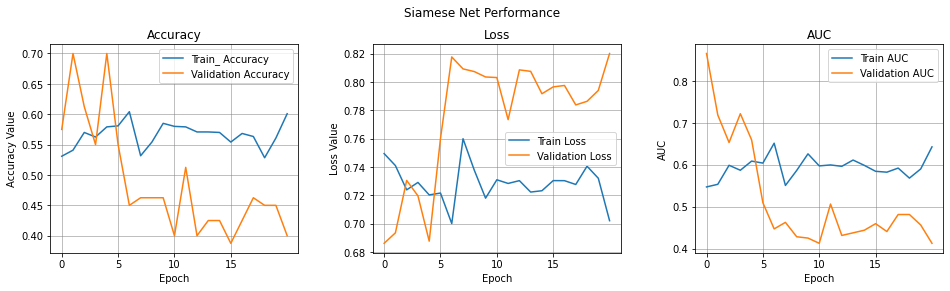

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['accuracy'], label='Train_ Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [20]:
siamese_net.load_weights('model_best_checkpoint.h5')